In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

from nibabel.viewers import OrthoSlicer3D

from segment_anything import SamAutomaticMaskGenerator
import supervision as sv

In [2]:
# Utils
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    
# SAM model
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

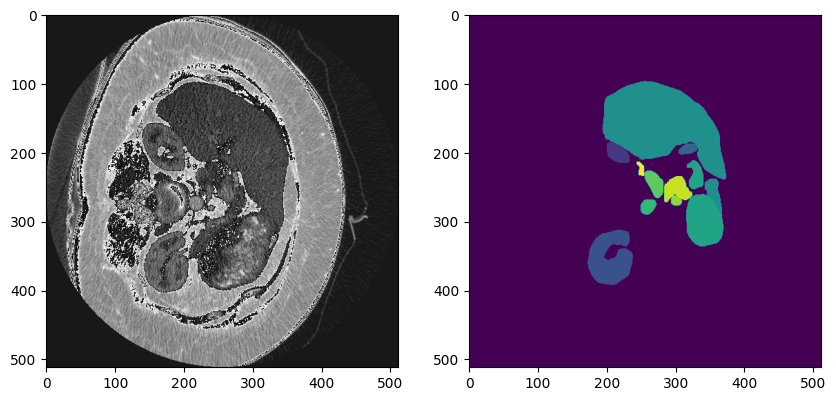

/home/vectorzhao/anaconda3/envs/sam/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


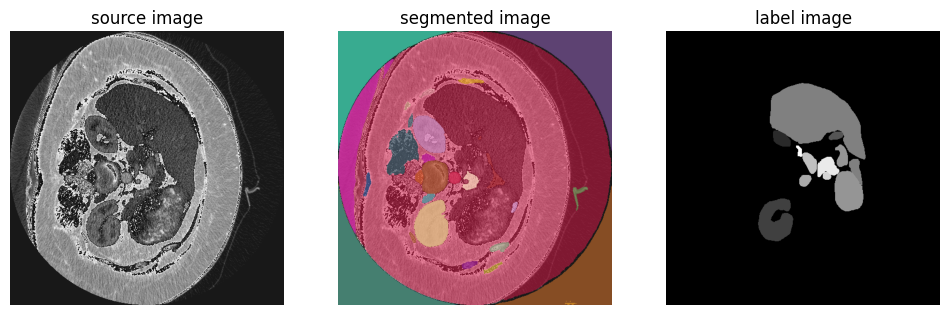

In [3]:
# Read data
import nibabel as nib
import imageio
import os

img_num = 0
img_z = 100

img_path = './data/RawData/Training/img/'
img_filenames = os.listdir(img_path)
image_nib = nib.load(img_path + img_filenames[img_num])
image = image_nib.get_fdata().astype(np.uint8)
image0 = image[:,:,img_z]
image0 = np.stack((image0,)*3, axis=-1)


label_path = './data/RawData/Training/label/'
label_filenames = os.listdir(label_path)
label_nib = nib.load(label_path + label_filenames[img_num])
label = label_nib.get_fdata().astype(np.uint8)
label0 = label[:,:,img_z]



plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image0)
plt.subplot(1, 2, 2)
plt.imshow(label0)
plt.show()

predictor.set_image(image0)


# SAM: mask generation
mask_generator = SamAutomaticMaskGenerator(sam)

sam_result = mask_generator.generate(image0)

mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image0.copy(), detections=detections)

sv.plot_images_grid(
    images=[image0, annotated_image, label0],
    grid_size=(1, 3),
    titles=['source image', 'segmented image', 'label image']
)


In [4]:
import torchmetrics
from torchmetrics.functional import dice

print(label0.shape)
print(label0.sum())
print(512*512)
label0 = torch.tensor(label0)
l = len(sam_result)
for i in range(l):
    print(i, sam_result[i]['segmentation'].sum())
    # print(len(sam_result[i]['segmentation']))
    s = torch.tensor(sam_result[i]['segmentation'])
    precison = dice(s, label0)
    print(precison)


(512, 512)
159558
262144
0 203732
tensor(0.2228)
1 4310
tensor(0.8881)
2 3258
tensor(0.8855)
3 4316
tensor(0.8880)
4 13896
tensor(0.8449)
5 8298
tensor(0.8663)
6 13618
tensor(0.8460)
7 13809
tensor(0.8452)
8 13545
tensor(0.8462)
9 13828
tensor(0.8452)
10 432
tensor(0.8963)
11 27003
tensor(0.7949)
12 459
tensor(0.8962)
13 308
tensor(0.8967)
14 154
tensor(0.8973)
15 116
tensor(0.8975)
16 2615
tensor(0.8879)
17 3377
tensor(0.8850)
18 294
tensor(0.8968)
19 314
tensor(0.8967)
20 169
tensor(0.8973)
21 654
tensor(0.8963)
22 283
tensor(0.8968)
23 323
tensor(0.8967)
24 361
tensor(0.8965)
25 160
tensor(0.8978)
26 262
tensor(0.8969)
27 30
tensor(0.8979)
28 638
tensor(0.8962)
29 376
tensor(0.8965)
30 231
tensor(0.8970)
